# <b>Deep Learning:</b>
# Improving existing segmentators performance with zero-shot segmentators

This Notebook implements the code used in our paper "Improving existing segmentators performance with zero-shot segmentators".

In our study, we used the predicted segmentation masks from state-of-the-art methods **DeepLabV3+** https://github.com/VainF/DeepLabV3Plus-Pytorch and **PVTv2** https://github.com/whai362/PVT.

From these masks, we produce some checkpoints to feed **SAM** (**Segment Anything**, https://github.com/facebookresearch/segment-anything) for *Post-Processing Segmentation Enhancement* or SEEM (**Segment Everything Everywhere All at Once**, https://github.com/UX-Decoder/Segment-Everything-Everywhere-All-At-Once) models.

The **Segment Anything Model (SAM)** produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

Similarly to SAM, **Segment Everything Everywhere All at Once (SEEM)** allows users to easily segment an image using prompts of different types including visual prompts (points, marks, boxes, scribbles and image segments) and language prompts (text and audio), etc. It can also work with any combinations of prompts or generalize to custom prompts.


We devised 4 different methods for producing checkpoints:
 - A: the pixel whose coordinates are, along each dimension, the average of value of all the mask's pixels coordinate
 - B: the center of mass of the mask
 - C: one (or more) pixels drawn (uniformly or not...) randomly inside the mask area
 - D: pixels drawn from the intersection of a uniform grid of fixed step size and the mask. "b" stands for the intersection between the grid and the eroded mask, where the mask is shrinked of 10 pixels.
---

### In order to run the script, you need to:
 - set the path to your data folder    (in "Parameters of the script" cell)
 - set the which type of DeepLabV3+ mask to consider (binary or real valued) (in "Run SAM" cell)

---



### Necessary imports

In [1]:
import torch                    ## pip install torch
import matplotlib.pyplot as plt ## pip install matplotlib
import cv2                      ## pip install opencv-python
from skimage import measure     ## pip install scikit-image
from scipy import ndimage       ## pip install scipy
from tqdm import tqdm           ## pip install tqdm

import numpy as np              ## pip install numpy
import pickle                   ## pip install pickle

import os,glob
import sys
sys.path.append("..")
np.set_printoptions(threshold=sys.maxsize)

import math

###
## to download SAM:
## git clone git@github.com:facebookresearch/segment-anything.git
## cd segment-anything; pip install -e .
###

from segment_anything import sam_model_registry, SamPredictor

c:\Users\gustavo\miniconda3\envs\sam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For reproducibility, seed of random generators

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Helper function for reading images and masks

In [3]:
def read_img(path:str) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def read_bmask(path:str) -> np.ndarray:
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.0

def read_rmask(path:str) -> np.ndarray:
    return cv2.imread(path, cv2.IMREAD_UNCHANGED) 

def get_data(paths:list) -> list:
    img_path, gt_mask_path, dplabv3_bmask_path, dplabv3_rmask_path = paths
    img           = read_img(img_path)
    gt_mask       = read_bmask(gt_mask_path)
    dplabv3_bmask = read_bmask(dplabv3_bmask_path)
    dplabv3_rmask = read_rmask(dplabv3_rmask_path)
    assert img.shape[:2] == gt_mask.shape == \
           dplabv3_bmask.shape == dplabv3_rmask.shape[:2], \
            f"Error: shape mismatch, {img.shape[:2]} {gt_mask.shape} {dplabv3_bmask.shape} {dplabv3_rmask.shape[:2]}"
    return img, gt_mask, dplabv3_bmask, dplabv3_rmask

### Helper functions for displaying points, boxes, and masks.

In [4]:
def show_mask(mask: np.ndarray, ax, random_color:bool=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords:np.ndarray, labels:np.ndarray, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) # this is if you want the star
    #ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=10, edgecolor='green', linewidth=1.25) # this is if you want the dot
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def draw_img(img:np.ndarray, input_point:np.ndarray=None, input_label:np.ndarray=None, \
             mask: np.ndarray=None, title:plt.title = None, plt_show:bool=True):
    plt.clf()
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    if mask is not None:
        show_mask(mask, plt.gca())
    if input_point is not None and input_label is not None:
        show_points(input_point, input_label, plt.gca())
    if title is not None:
        plt.title(title, fontsize=18)
    plt.axis('off')
    if plt_show:
        plt.show()
        
def draw_results(masks:list, scores:list, gt_mask:np.ndarray, \
                 input_point:np.ndarray, input_label:np.ndarray):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        iou = get_iou(mask, gt_mask)
        title = f"Mask {i+1}, Score: {score:.3f}, IoU: {iou:.3f}"
        draw_img(img, input_point, input_label, mask, title)

### Helper function for computing how many blobs a mask contains

In [5]:
def get_mask_of_blobs(mask: np.ndarray) -> np.ndarray:
    # compute how many blobs a mask contains
    # @return: a mask in which each pixel is assigned a blob ID
    mask_of_blobs = measure.label(mask)
    return mask_of_blobs

### Helper function for logging

In [6]:
def log(paths: tuple):
    img_path, gt_mask_path, dplabv3_bmask_path, dplabv3_rmask_path = paths
    print("img_path          :", img_path)
    print("gt_mask_path      :", gt_mask_path)
    print("dplabv3_bmask_path:", dplabv3_bmask_path)
    print("dplabv3_rmask_path:", dplabv3_rmask_path)

### Metrics
(between a predicted mask and a Ground Truth mask)

In [7]:
class Metrics():
    eps=np.finfo(np.double).eps
    
    def reset(self):
        self.ious, self.maes, self.dices, self.wfms, self.emes = [], [], [], [], []
        self.tps, self.fps, self.tns, self.fns = 0, 0, 0, 0
    
    def step_common(self, pred, GT):
        iou       = self.get_iou(pred, GT)
        dice      = self.get_dice(pred, GT)
        mae       = self.compute_mae(pred, GT)
        fscore    = self.FbetaMeasure(pred.astype(bool), GT.astype(bool))
        e_measure = self.EMeasure(pred.astype(bool), GT.astype(bool))
        self.ious.append(iou)
        self.dices.append(dice)
        self.maes.append(mae)
        self.wfms.append(fscore)
        self.emes.append(e_measure)
    
    def step_skin(self, pred, gt):
        y_pred_bool = pred.astype(bool)
        y_true_bool = gt.astype(bool)
        self.tps += np.logical_and(y_true_bool, y_pred_bool).sum()
        self.tns += np.logical_and(~y_true_bool, ~y_pred_bool).sum()
        self.fps += np.logical_and(~y_true_bool, y_pred_bool).sum()
        self.fns += np.logical_and(y_true_bool, ~y_pred_bool).sum()
        
        
    def step_locuste(self, pred, GT):
        iou       = self.get_iou_locuste(pred, GT)
        dice      = self.get_dice_locuste(pred.astype(bool), GT.astype(bool))
        mae       = self.compute_mae(pred, GT)
        e_measure = self.EMeasure(pred.astype(bool), GT.astype(bool))
        fscore    = self.FbetaMeasure(pred.astype(bool), GT.astype(bool))
        self.ious.append(iou)
        self.dices.append(dice)
        self.maes.append(mae)
        self.wfms.append(fscore)
        self.emes.append(e_measure)
        
    
    def get_iou_common(self, pred, gt, beta=1):
        y_pred_bool = pred.astype(bool)
        y_true_bool = gt.astype(bool)
        tp = np.logical_and(y_true_bool, y_pred_bool).sum()
        tn = np.logical_and(~y_true_bool, ~y_pred_bool).sum()
        fp = np.logical_and(~y_true_bool, y_pred_bool).sum()
        fn = np.logical_and(y_true_bool, ~y_pred_bool).sum()
        if tp+fn+fp==0:
            if tp==0:
                iou=1.0
            else:
                iou=0.0
        else:
            iou = tp / (tp + fn + fp)

        return iou

    def get_iou_locuste(self, pred, target, n_classes = 2):
        return jaccard_score(target.reshape(-1).astype(bool), pred.reshape(-1).astype(bool))

    def get_dice_common(self, pred, gt):
        y_pred_bool = pred.astype(bool)
        y_true_bool = gt.astype(bool)

        tp = np.logical_and( y_true_bool,  y_pred_bool).sum()
        tn = np.logical_and(~y_true_bool, ~y_pred_bool).sum()
        fp = np.logical_and(~y_true_bool,  y_pred_bool).sum()
        fn = np.logical_and( y_true_bool, ~y_pred_bool).sum()
        
        if tp+fn+fp==0:
            dice=1.0 if tp==0 else 0.0
        else:
            dice = 2*tp / (2*tp + fn + fp)

        return dice

    def _calConfusion(self, pred, GT):
        TP=np.sum(pred[GT]==1)
        FP=np.sum(pred[~GT]==1)
        TN=np.sum(pred[~GT]==0)
        FN=np.sum(pred[GT]==0)
        return TP,FP,TN,FN

    def get_dice_locuste(self, pred, GT):
        tp, fp, tn, fn = _calConfusion(pred, GT)
        return (2.0 * tp) / (2.0 * tp + fp + fn + 1e-7)

    def compute_mae(self, pred: np.ndarray, gt: np.ndarray) -> np.ndarray:
        mae = np.mean(np.abs(pred - gt))
        return mae
    
    ## F-Measure
    def FbetaMeasure(self, pred, GT, beta= math.sqrt(0.3)):
        TP,FP,TN,FN=self._calConfusion(pred, GT)
        if TP+FN+FN==0:
            if TP==0:
                Fbeta=1.0
            else:
                Fbeta=0.0
        else:
            P=TP/(TP+FP+1e-8) #precision
            R=TP/(TP+FN+1e-8) #recall
            Fbeta=(beta**2+1)*P*R/((beta**2)*P+R+1e-8)
        return Fbeta
    
    ## E-Measure
    def _EnhancedAlignmnetTerm(self, align_Matrix):
        enhanced=((align_Matrix+1)**2)/4
        return enhanced

    def _AlignmentTerm(self, dGT, dpred):
        mean_dpred=np.mean(dpred)
        mean_dGT=np.mean(dGT)
        align_dpred=dpred-mean_dpred
        align_dGT=dGT-mean_dGT
        align_matrix=2*(align_dGT*align_dpred)/(align_dGT**2+align_dpred**2+self.eps)
        return align_matrix

    def EMeasure(self, pred, GT):
        dGT,dpred=GT.astype(np.float64),pred.astype(np.float64)
        if np.sum(GT)==0:#completely black
            enhanced_matrix=1-dpred
        elif np.sum(~GT)==0:
            enhanced_matrix=dpred
        else:
            align_matrix=self._AlignmentTerm(dGT,dpred)
            enhanced_matrix=self._EnhancedAlignmnetTerm(align_matrix)
        rows,cols= GT.shape
        
        # score=np.sum(enhanced_matrix)/(rows*cols-1+self.eps)
        score=np.sum(enhanced_matrix)/(rows*cols+self.eps)
        return score
    
    def get_results_common(self) -> (float, float, float, float, float):
        return np.array(self.ious).mean(), np.array(self.dices).mean(), np.array(self.maes).mean(), np.array(self.wfms).mean(), np.array(self.emes).mean()

    def get_results_skin(self):
        iou = self.tps / (self.tps + self.fns + self.fps)
        dice = (2.0 * self.tps) / (2.0 * self.tps + self.fps + self.fns + 1e-7)
        # for skin dataset, we didn't need the other metrics. TODO: implement
        return iou, dice, None, None, None
    
    def set_mode_locuste(self):
        self.step = self.step_locuste
        self.get_iou = self.get_iou_locuste
        self.get_dice = self.get_dice_locuste
    
    def set_mode_skin(self):
        self.step = self.step_skin
        self.get_results = self.get_results_skin
        
    def __init__(self, dataset=None):
        self.reset()
        self.step        = self.step_common
        self.get_iou     = self.get_iou_common
        self.get_dice    = self.get_dice_common
        self.get_results = self.get_results_common
        if "SKIN" in dataset:
            self.set_mode_skin()
        elif "Locuste" in dataset:
            self.set_mode_locuste()
            
    

### Functions for the sampling of the checkpoints.

In [8]:

class Sampler:
    verbose = True
    sampling_step = None
    min_blob_count = None
    def __init__(self, verbose, sampling_step, min_blob_count):
        self.verbose        = verbose
        self.sampling_step  = sampling_step
        self.min_blob_count = min_blob_count
    
    def sample_pixels(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                x_center, y_center = np.argwhere(mask_bool).sum(0)/count
                x_center, y_center = int(x_center) % mask.shape[0], int(y_center) % mask.shape[1]
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? pick the center pixel of image
        if len(input_point) == 0:
            input_point, input_label = [[mask.shape[1]//2, mask.shape[0]//2]], [1]

        return np.array(input_point), np.array(input_label)
    
    def sample_pixels_center_of_mass(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                x_center, y_center = ndimage.center_of_mass(mask_bool)
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? pick the center pixel of image
        if len(input_point) == 0:
            input_point, input_label = [[mask.shape[1]//2, mask.shape[0]//2]], [1]
            print(f"empty blob -> {input_point}") if self.verbose else None

        return np.array(input_point), np.array(input_label)

    def sample_pixels_random(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                indices = np.argwhere(mask_bool)
                random_index = np.random.choice(indices.shape[0])
                x_center, y_center = indices[random_index]
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? sample a random point
        if len(input_point) == 0:
            input_point, input_label = [ \
                [np.random.randint(0, mask.shape[1]),   \
                 np.random.randint(0, mask.shape[0])]], \
            [1]

        return np.array(input_point), np.array(input_label)

    def get_grid(self, mask, offset_px_x, offset_px_y):
        row = np.zeros(mask.shape, dtype=int)
        col = np.zeros(mask.shape, dtype=int)

        for i in range(offset_px_y, row.shape[0], self.sampling_step):
            row[i, :] = 1
        for i in range(offset_px_x, col.shape[1], self.sampling_step):
            col[:, i] = 1
        res = row & col
        return res
    
    def sample_pixels_grid(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):

        # draw a pix for each blob
        input_point = []
        offset_px_x = 0
        offset_px_y = 0
        while len(input_point)==0 and offset_px_y < self.sampling_step:
            res = self.get_grid(mask, offset_px_x, offset_px_y)

            input_point = np.argwhere(res & mask.astype(np.int64))
            input_point[:, (0, 1)] = input_point[:, (1, 0)]
            
            offset_px_x += 1
            if offset_px_x>self.sampling_step:
                offset_px_x = 0
                offset_px_y += 1

        # STILL no mask? sample a random point
        blob_labels = np.unique(mask_of_blobs)
        if len(input_point) <= blob_labels.shape[0]-1:
            return self.sample_pixels_random(mask_of_blobs, mask)

        input_label = [1 for _ in input_point]
        

        return np.array(input_point), np.array(input_label)
    
    def sample_pixels_eroded_grid(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        
        input_point = []
        offset_px_x = 0
        offset_px_y = 0
        
        while len(input_point)==0 and offset_px_y < self.sampling_step:
            res = self.get_grid(mask, offset_px_x, offset_px_y)
            erode_size = 10
        
            while True:
                # Erode the mask
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erode_size, erode_size))
                eroded_mask = cv2.erode(mask, kernel)

                input_point = np.argwhere(res & eroded_mask.astype(np.int64))
                input_point[:, (0, 1)] = input_point[:, (1, 0)]

                blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
                gt_fl = mask.flatten()

                blobs = np.zeros(blob_labels.shape[0], dtype=np.float32)
                for i, (bl, bs) in enumerate(zip(blob_labels, blob_sample)):
                    mask_bool = (mask_of_blobs==bl)
                    count = mask_bool.sum()
                    if not (gt_fl[bs]>=1.0 and count>self.min_blob_count): ## it's not a background blob or a false blob
                        blobs[i] = -1

                for i in range(input_point.shape[0]):
                    fl_ip = input_point[i][0]*mask.shape[1] + input_point[i][1]
                    idx = mask_of_blobs[input_point[i][1], input_point[i][0]]
                    blobs[idx]=1.0
                
                if not np.any(blobs==0.0) or erode_size==1:
                    break
                erode_size -= 1
            
            offset_px_x += 1
            if offset_px_x>self.sampling_step:
                offset_px_x = 0
                offset_px_y += 1
            
        
        input_label = [1 for _ in input_point]

        # still no mask? sample a random point
        if len(input_point) == 0:
            return self.sample_pixels_grid(mask_of_blobs, mask)

        return np.array(input_point), np.array(input_label)
    
    def sample(self, mode, border_mode, mask_of_blobs: np.ndarray, mask: np.ndarray):
        if mode=="A":
            return self.sample_pixels(mask_of_blobs, mask)
        elif mode=="B":
            return self.sample_pixels_center_of_mass(mask_of_blobs, mask)
        elif mode=="C":
            return self.sample_pixels_random(mask_of_blobs, mask)
        elif mode=="D":
            if border_mode=="on":
                return self.sample_pixels_eroded_grid(mask_of_blobs, mask)
            else:
                return self.sample_pixels_grid(mask_of_blobs, mask)


## visualize an example

In [10]:
# img           = read_img ("images/test/camourflage_00012.jpg")
# gt_mask       = read_bmask("images/labels/1.bmp")
# dplabv3_bmask = read_bmask("images/deeplab_masks/1.bmp")


# # for each computed mask, show the superposition with the original image
# # and SAM's predicted score and IoU wrt Ground Truth mask
# plt.clf()
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
# axes[0].imshow(img)
# axes[1].imshow(gt_mask)
# axes[2].imshow(dplabv3_bmask)
# fig.tight_layout()
# plt.show()

### Parameters of the script

In [9]:
verbose           = False

## Data settings
dataset_path     = "c:\\Users\\gustavo\\Documents\\SAM\\data\\test"   ## Put your PATH here!
base_output_path = "c:\\Users\\gustavo\\Documents\\SAM\\outputs\\test\\original"   ## Put your PATH here!


def get_complete_output_path(bop, dataset_name, src_msk, model, create=False):
    results_dir = os.path.join(bop, dataset_name, src_msk, model)
    if create:
        os.makedirs(results_dir, exist_ok=True)
    return results_dir

## get sample points folder path
def get_spf_path(bop, dataset_name, src_msk, model, psm, s_step, bm, create=False):
    sampled_points_folder = os.path.join(bop, "sampled_points_final", dataset_name, src_msk, model, \
                                psm + (("_" + str(s_step)) if psm=="D" else "") \
                                + ("_bm" if bm=="on" and psm=="D" else ""))
    if create:
        os.makedirs(sampled_points_folder, exist_ok=True)
    return sampled_points_folder


def get_min_blob_number_based_on_dataset(dataset):
    return 20 if dataset=="portrait" else 10

## paths

## Check datasets health

In [10]:
datasets = ["CAMO", "Portrait", "Locuste", "Ribs", \
            "SKIN/SKIN_COMPAQ", "SKIN/SKIN_ECU", "SKIN/SKIN_HANDGESTURE", "SKIN/SKIN_MCG", \
            "SKIN/SKIN_Pratheepan", "SKIN/SKIN_Schmugge", "SKIN/SKIN_SFA", \
            "SKIN/SKIN_uchile", "SKIN/SKIN_VMD", "SKIN/SKIN_VT-AAST", \
            "Butterfly/FoldDA1_1", "Butterfly/FoldDA1_2", "Butterfly/FoldDA1_3", "Butterfly/FoldDA1_4", \
            "COCO_val2017", "MARS"]

max_length = len(max(datasets, key=len))

for dataset in datasets:
    path = os.path.join(dataset_path, dataset)
    
    # 1. check "imgs" exists and count files in it
    # if not, print a big warning (imgs does not exists)
    # 2. check   "gt" exists and count files in it
    # if not, print a big warning (gt does not exists)
    # get all directories starting with "segmentator_"
    #   for each, count files in it
    # if empty: print warning (no segmentator -> only oracle is available)
    
    imgs_num = gt_num = 0
    segm_num = {}
    
    imgs_exists = os.path.isdir(os.path.join(path, "imgs"))
    gt_exists   = os.path.isdir(os.path.join(path, "gt"))
    segmentators = glob.glob(os.path.join(path, "segmentator_*"))
    
    if imgs_exists:
        imgs_num = len(glob.glob(os.path.join(path, "imgs", "*")))
    
    if gt_exists:
        gt_num = len(glob.glob(os.path.join(path, "gt", "*")))
    
    print(f"{dataset.ljust(max_length)} | {imgs_num:8d} | {gt_num:8d}", end="", flush=True)
    
    for idx, segmentator in enumerate(segmentators):
        num = len(glob.glob(os.path.join(segmentator, "*.bmp")))
        print(f" - {os.path.basename(segmentator)[12:]} ({num})", end="", flush=True)
    print()


CAMO                  |        0 |        0
Portrait              |        0 |        0
Locuste               |        0 |        0
Ribs                  |       49 |       49 - deeplab (49)
SKIN/SKIN_COMPAQ      |        0 |        0
SKIN/SKIN_ECU         |        0 |        0
SKIN/SKIN_HANDGESTURE |        0 |        0
SKIN/SKIN_MCG         |        0 |        0
SKIN/SKIN_Pratheepan  |        0 |        0
SKIN/SKIN_Schmugge    |        0 |        0
SKIN/SKIN_SFA         |        0 |        0
SKIN/SKIN_uchile      |        0 |        0
SKIN/SKIN_VMD         |        0 |        0
SKIN/SKIN_VT-AAST     |        0 |        0
Butterfly/FoldDA1_1   |        0 |        0
Butterfly/FoldDA1_2   |        0 |        0
Butterfly/FoldDA1_3   |        0 |        0
Butterfly/FoldDA1_4   |        0 |        0
COCO_val2017          |        0 |        0
MARS                  |        0 |        0


In [11]:
def loadpaths(dataset_path, dataset_name, segmentator_name):
    
    if not os.path.isdir(os.path.join(dataset_path, dataset_name)):
        print("ERROR. provided dataset does not exist!")
        return None
    
    orig_images_folder = os.path.join(dataset_path, dataset_name, "imgs")
    gt_folder          = os.path.join(dataset_path, dataset_name, "gt")
    segmentator_folder = os.path.join(dataset_path, dataset_name, "segmentator_" + segmentator_name)
    
    ## Load input images ##
    test_imgs = glob.glob(os.path.join(orig_images_folder, '*'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in test_imgs]
    test_imgs = [test_imgs[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]
    
    ## Load GT masks ##
    gt_masks = glob.glob(os.path.join(gt_folder, '*'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in gt_masks]
    gt_masks = [gt_masks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]
    
    print(os.path.join(segmentator_folder, '*.bmp'))

    ## Load DeepLabV3+ produced binary masks ##
    segmentator_bmasks = glob.glob(os.path.join(segmentator_folder, '*.bmp'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in segmentator_bmasks]
    segmentator_bmasks = [segmentator_bmasks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]

    # ## Load DeepLabV3+ produced 3D masks ##
    segmentator_rmasks = glob.glob(os.path.join(segmentator_folder, '*.png'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in segmentator_rmasks]
    segmentator_rmasks = [segmentator_rmasks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]
        
    return test_imgs, gt_masks, segmentator_bmasks, segmentator_rmasks


## Run SAM

Predict with `SamPredictor.predict`. The model returns
 - masks  (`masks.shape  # (number_of_masks) x H x W) ` )
 - quality predictions for those masks
 - low resolution mask logits that can be passed to the next iteration of prediction.

The `predict()` function accepts three parameters (among many):

 - `point_coords`: an np.ndarray of 2D pixels that will provide SAM the checkpoints/seeds of the object to segment
 - `point_labels`: is the corresponding pixel a pixel belonging to the object (1) or not (0) ?

 - With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [12]:

def perform(predictor, model_type, source_mask, dataset, points_sampling_mode, sampling_step, border_mode):
    global verbose
    
    min_blob_count = get_min_blob_number_based_on_dataset(dataset)
    
    test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(dataset_path, dataset, source_mask)

    assert len(test_imgs) == len(gt_masks) == len(src_bmasks) == len(src_rmasks),\
              f"unbalanced datasets! {len(test_imgs)} {len(gt_masks)} {len(src_rmasks)}"
    
    toiterate = zip(test_imgs, gt_masks, src_bmasks, src_rmasks)

    print("len of files:", len(test_imgs)) if verbose else None
    
    sampler = Sampler(verbose, sampling_step, min_blob_count)
    
    results_dir = get_complete_output_path(base_output_path, dataset, source_mask, model_type, create=True)
    sampled_points_folder = get_spf_path(base_output_path, dataset, source_mask, model_type, points_sampling_mode, sampling_step, border_mode, create=True)
    
    print("results will be saved at for results_dir", results_dir)
    
    for idx, paths in tqdm(enumerate(toiterate), total=len(test_imgs)):
        
        print(f" - img idx {str(idx+1).zfill(6)}/{len(test_imgs)}:") if verbose else None
        
        # Get paths
        img_path, gt_mask_path, src_bmask_path, src_rmask_path = paths
        log(paths) if verbose else None
        
        # Load images from disk using paths
        img           = read_img(img_path)
        gt_mask       = read_bmask(gt_mask_path)
        src_bmask = read_bmask(src_bmask_path)
        src_rmask = read_rmask(src_rmask_path)
        
        if source_mask=="oracle":
            assert img.shape[:2] == gt_mask.shape, f"Error: shape mismatch {img.shape[:2]} {gt_mask.shape}"
        else:
            assert img.shape[:2] == gt_mask.shape == \
                src_bmask.shape == src_rmask.shape[:2], f"Error: shape mismatch {img.shape[:2]} {gt_mask.shape} {src_bmask.shape} {src_rmask.shape[:2]}"
        
        # mask_to_sample = dplabv3_bmask
        if source_mask=="oracle":
            mask_to_sample = gt_mask
        else:
            mask_to_sample = src_bmask

        # Count the number of distinct labels (it corresponds to the number of blobs)
        mask_of_blobs = get_mask_of_blobs(mask_to_sample)
        
        # Sample the checkpoints (at least one for blob)
        unique_blobs = np.unique(mask_of_blobs)
        num_blobs = unique_blobs.shape[0]
        if num_blobs==1 and 0 in unique_blobs:
            input_point = input_label= np.array([])
            input_point.tofile(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin_"))
            binary_mask = mask_to_sample
            masks=[binary_mask]
            best_score_idx=0
        else:
            input_point, input_label = sampler.sample(points_sampling_mode, border_mode, mask_of_blobs, mask_to_sample)
            input_point.tofile(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin_"))

            print("setting image on predictor", end="... ")  if verbose else None
            predictor.set_image(img)

            print("predicting", end="... ")  if verbose else None
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
                return_logits=True
            )
            torch.cuda.empty_cache()

            best_score_idx = np.argmax(scores)
            binary_mask = masks[best_score_idx] > 0
        
#         # TO VISUALIZE computed mask, show the superposition with the original image
#         # and SAM's predicted score and IoU wrt Ground Truth mask
#         plt.clf()
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
#         axes[0].imshow(img)
#         if input_point.shape[0]>0:
#             axes[0].scatter([input_point[:, 0]], [input_point[:, 1]], color='green', marker='*', s=100, edgecolor='white', linewidth=1.25) # this is if you want the star
#         axes[1].imshow(gt_mask)
#         axes[2].imshow(mask_to_sample)
#         axes[3].imshow(binary_mask)
#         fig.tight_layout()
#         plt.show()
#         break
        
        ## this is how we saved the produced masks
        basename = os.path.basename(img_path)
        out_mask_path = results_dir + "/" + basename[:basename.rfind(".")+1]+"jpg"
        cv2.imwrite(out_mask_path, masks[best_score_idx]*255)


In [13]:
def perform_all(dataset_name, predictor, model_type, source_mask, ):
    with torch.no_grad():
        # perform(predictor, model_type, source_mask, dataset_name, "A", None, None)
        # perform(predictor, model_type, source_mask, dataset_name, "B", None, None)
        # perform(predictor, model_type, source_mask, dataset_name, "C", None, None)
        # perform(predictor, model_type, source_mask, dataset_name, "D", 10, "on")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 30, "on")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 50, "on")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 100, "on")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 10, "off")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 30, "off")
        perform(predictor, model_type, source_mask, dataset_name, "D", 50, "off")
        # perform(predictor, model_type, source_mask, dataset_name, "D", 100, "off")

## USE VIT-L

results will be saved at for results_dir /home/fusaro/segment-anything/SAM_outputs/CAMO/deeplab/default


  0%|          | 0/250 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

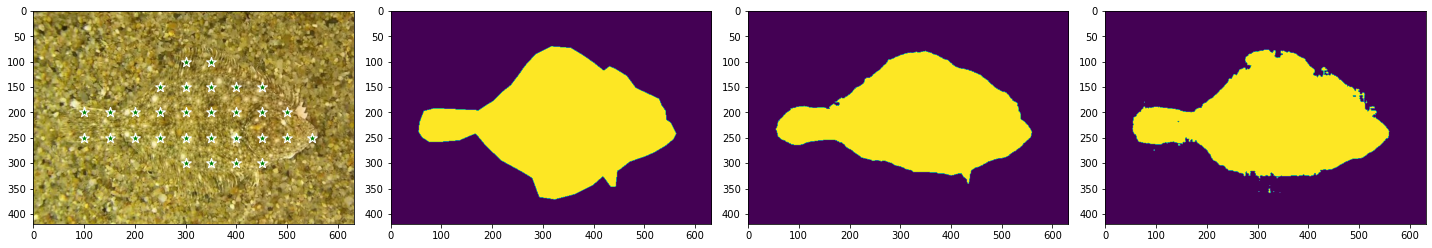

  0%|          | 0/250 [00:01<?, ?it/s]


In [26]:
device = "cuda" # ["cuda", "cpu"]
sam_checkpoint = os.path.join("c:\\Users\\gustavo\\Documents\\SAM\\pretrained_models", "sam_vit_l_0b3195.pth")
model_type = "vit_l"
source_mask = "deeplab" # ["oracle", "deeplab", "pvtv2", "sota"] ### it depends, choose wisely!

# print(f"creating sam {model_type} and moving it to device")
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
# print("creating predictor")
# predictor = SamPredictor(sam)  

# CHOOSE ONE (OR MANY)
datasets = []
# datasets.append("CAMO")
# datasets.append("portrait")
# datasets.append("locuste")
datasets.append("ribs")
# datasets.append("SKIN/SKIN_COMPAQ")
# datasets.append("SKIN/SKIN_ECU")
# datasets.append("SKIN/SKIN_HANDGESTURE")
# datasets.append("SKIN/SKIN_MCG")
# datasets.append("SKIN/SKIN_Pratheepan")
# datasets.append("SKIN/SKIN_Schmugge")
# datasets.append("SKIN/SKIN_SFA")
# datasets.append("SKIN/SKIN_uchile")
# datasets.append("SKIN/SKIN_VMD")
# datasets.append("SKIN/SKIN_VT-)
# datasets.append("Butterfly/FoldDA1_1")
# datasets.append("Butterfly/FoldDA1_2")
# datasets.append("Butterfly/FoldDA1_3")
# datasets.append("Butterfly/FoldDA1_4")
# datasets.append("COCO_val2017")
# datasets.append("MARS")

for dataset in datasets:
    perform_all(dataset, predictor, model_type, source_mask)


## USE VIT-H

In [14]:
device = "cpu" # ["cuda", "cpu"]
verbose = True
sam_checkpoint = os.path.join("c:\\Users\\gustavo\\Documents\\SAM\\pretrained_models", "sam_vit_h_4b8939.pth")
model_type = "default"
source_mask = "deeplab" # ["oracle", "deeplab", "pvtv2"]

print(f"creating sam {model_type} and moving it to device")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print("creating predictor")
predictor = SamPredictor(sam)  

# CHOOSE ONE (OR MANY)
datasets = []
# datasets.append("CAMO")
# datasets.append("Portrait")
# datasets.append("Locuste")
datasets.append("ribs")
# datasets.append("SKIN/SKIN_COMPAQ")
# datasets.append("SKIN/SKIN_ECU")
# datasets.append("SKIN/SKIN_HANDGESTURE")
# datasets.append("SKIN/SKIN_MCG")
# datasets.append("SKIN/SKIN_Pratheepan")
# datasets.append("SKIN/SKIN_Schmugge")
# datasets.append("SKIN/SKIN_SFA")
# datasets.append("SKIN/SKIN_uchile")
# datasets.append("SKIN/SKIN_VMD")
# datasets.append("SKIN/SKIN_VT-)
# datasets.append("Butterfly/FoldDA1_1")
# datasets.append("Butterfly/FoldDA1_2")
# datasets.append("Butterfly/FoldDA1_3")
# datasets.append("Butterfly/FoldDA1_4")
# datasets.append("COCO_val2017")
# datasets.append("MARS")

for dataset in datasets:
    perform_all(dataset, predictor, model_type, source_mask)


creating sam default and moving it to device
creating predictor
c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\*.bmp
len of files: 49
results will be saved at for results_dir c:\Users\gustavo\Documents\SAM\outputs\test\original\ribs\deeplab\default


  0%|          | 0/49 [00:00<?, ?it/s]

 - img idx 000001/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\785.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\785.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\785.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\785.png
setting image on predictor... predicting... 

  2%|▏         | 1/49 [01:11<57:17, 71.61s/it]

 - img idx 000002/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\786.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\786.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\786.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\786.png
setting image on predictor... predicting... 

  4%|▍         | 2/49 [02:21<55:27, 70.79s/it]

 - img idx 000003/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\787.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\787.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\787.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\787.png
setting image on predictor... predicting... 

  6%|▌         | 3/49 [03:28<52:57, 69.07s/it]

 - img idx 000004/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\788.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\788.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\788.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\788.png
setting image on predictor... predicting... 

  8%|▊         | 4/49 [04:27<48:37, 64.84s/it]

 - img idx 000005/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\789.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\789.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\789.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\789.png
setting image on predictor... predicting... 

 10%|█         | 5/49 [05:27<46:19, 63.16s/it]

 - img idx 000006/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\790.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\790.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\790.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\790.png
setting image on predictor... predicting... 

 12%|█▏        | 6/49 [06:23<43:30, 60.72s/it]

 - img idx 000007/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\791.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\791.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\791.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\791.png
setting image on predictor... predicting... 

 14%|█▍        | 7/49 [07:18<41:12, 58.88s/it]

 - img idx 000008/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\792.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\792.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\792.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\792.png
setting image on predictor... predicting... 

 16%|█▋        | 8/49 [08:22<41:17, 60.42s/it]

 - img idx 000009/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\793.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\793.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\793.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\793.png
setting image on predictor... predicting... 

 18%|█▊        | 9/49 [09:18<39:29, 59.25s/it]

 - img idx 000010/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\794.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\794.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\794.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\794.png
setting image on predictor... predicting... 

 20%|██        | 10/49 [10:16<38:17, 58.91s/it]

 - img idx 000011/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\795.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\795.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\795.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\795.png
setting image on predictor... predicting... 

 22%|██▏       | 11/49 [11:07<35:41, 56.35s/it]

 - img idx 000012/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\796.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\796.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\796.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\796.png
setting image on predictor... predicting... 

 24%|██▍       | 12/49 [12:00<34:02, 55.19s/it]

 - img idx 000013/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\797.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\797.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\797.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\797.png
setting image on predictor... predicting... 

 27%|██▋       | 13/49 [12:55<33:07, 55.22s/it]

 - img idx 000014/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\798.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\798.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\798.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\798.png
setting image on predictor... predicting... 

 29%|██▊       | 14/49 [13:57<33:25, 57.29s/it]

 - img idx 000015/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\799.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\799.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\799.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\799.png
setting image on predictor... predicting... 

 31%|███       | 15/49 [14:55<32:37, 57.56s/it]

 - img idx 000016/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\800.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\800.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\800.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\800.png
setting image on predictor... 

 33%|███▎      | 16/49 [15:52<31:33, 57.36s/it]

predicting...  - img idx 000017/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\801.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\801.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\801.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\801.png
setting image on predictor... predicting... 

 35%|███▍      | 17/49 [16:51<30:54, 57.96s/it]

 - img idx 000018/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\802.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\802.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\802.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\802.png
setting image on predictor... predicting... 

 37%|███▋      | 18/49 [17:46<29:24, 56.90s/it]

 - img idx 000019/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\803.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\803.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\803.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\803.png
setting image on predictor... predicting... 

 39%|███▉      | 19/49 [18:36<27:26, 54.89s/it]

 - img idx 000020/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\804.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\804.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\804.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\804.png
setting image on predictor... predicting... 

 41%|████      | 20/49 [19:32<26:38, 55.11s/it]

 - img idx 000021/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\805.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\805.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\805.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\805.png
setting image on predictor... predicting... 

 43%|████▎     | 21/49 [20:28<25:50, 55.38s/it]

 - img idx 000022/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\806.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\806.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\806.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\806.png
setting image on predictor... 

 45%|████▍     | 22/49 [21:19<24:19, 54.04s/it]

predicting...  - img idx 000023/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\807.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\807.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\807.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\807.png
setting image on predictor... 

 47%|████▋     | 23/49 [22:07<22:41, 52.37s/it]

predicting...  - img idx 000024/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\808.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\808.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\808.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\808.png
setting image on predictor... 

 49%|████▉     | 24/49 [22:57<21:34, 51.79s/it]

predicting...  - img idx 000025/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\809.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\809.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\809.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\809.png
setting image on predictor... predicting... 

 51%|█████     | 25/49 [23:52<21:05, 52.73s/it]

 - img idx 000026/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\810.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\810.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\810.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\810.png
setting image on predictor... predicting... 

 53%|█████▎    | 26/49 [24:56<21:28, 56.03s/it]

 - img idx 000027/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\811.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\811.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\811.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\811.png
setting image on predictor... predicting... 

 55%|█████▌    | 27/49 [25:56<20:57, 57.14s/it]

 - img idx 000028/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\812.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\812.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\812.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\812.png
setting image on predictor... predicting... 

 57%|█████▋    | 28/49 [26:55<20:10, 57.65s/it]

 - img idx 000029/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\813.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\813.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\813.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\813.png
setting image on predictor... predicting... 

 59%|█████▉    | 29/49 [27:52<19:10, 57.52s/it]

 - img idx 000030/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\814.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\814.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\814.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\814.png
setting image on predictor... predicting... 

 61%|██████    | 30/49 [28:46<17:55, 56.61s/it]

 - img idx 000031/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\815.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\815.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\815.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\815.png
setting image on predictor... 

 63%|██████▎   | 31/49 [29:44<17:02, 56.82s/it]

predicting...  - img idx 000032/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\816.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\816.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\816.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\816.png
setting image on predictor... predicting... 

 65%|██████▌   | 32/49 [30:34<15:31, 54.80s/it]

 - img idx 000033/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\817.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\817.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\817.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\817.png
setting image on predictor... predicting... 

 67%|██████▋   | 33/49 [31:28<14:33, 54.58s/it]

 - img idx 000034/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\818.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\818.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\818.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\818.png
setting image on predictor... predicting... 

 69%|██████▉   | 34/49 [32:24<13:47, 55.19s/it]

 - img idx 000035/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\819.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\819.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\819.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\819.png
setting image on predictor... predicting... 

 71%|███████▏  | 35/49 [33:21<12:59, 55.67s/it]

 - img idx 000036/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\820.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\820.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\820.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\820.png
setting image on predictor... predicting... 

 73%|███████▎  | 36/49 [34:20<12:15, 56.61s/it]

 - img idx 000037/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\821.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\821.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\821.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\821.png
setting image on predictor... predicting... 

 76%|███████▌  | 37/49 [35:17<11:19, 56.64s/it]

 - img idx 000038/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\822.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\822.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\822.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\822.png
setting image on predictor... 

 78%|███████▊  | 38/49 [36:16<10:30, 57.33s/it]

predicting...  - img idx 000039/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\823.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\823.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\823.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\823.png
setting image on predictor... predicting... 

 80%|███████▉  | 39/49 [37:08<09:17, 55.77s/it]

 - img idx 000040/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\824.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\824.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\824.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\824.png
setting image on predictor... predicting... 

 82%|████████▏ | 40/49 [38:03<08:19, 55.54s/it]

 - img idx 000041/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\825.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\825.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\825.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\825.png
setting image on predictor... predicting... 

 84%|████████▎ | 41/49 [38:57<07:21, 55.22s/it]

 - img idx 000042/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\826.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\826.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\826.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\826.png
setting image on predictor... predicting... 

 86%|████████▌ | 42/49 [39:53<06:26, 55.22s/it]

 - img idx 000043/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\827.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\827.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\827.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\827.png
setting image on predictor... predicting... 

 88%|████████▊ | 43/49 [40:50<05:35, 55.97s/it]

 - img idx 000044/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\828.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\828.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\828.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\828.png
setting image on predictor... predicting... 

 90%|████████▉ | 44/49 [41:49<04:44, 56.81s/it]

 - img idx 000045/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\829.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\829.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\829.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\829.png
setting image on predictor... predicting... 

 92%|█████████▏| 45/49 [42:46<03:46, 56.71s/it]

 - img idx 000046/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\830.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\830.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\830.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\830.png
setting image on predictor... 

 94%|█████████▍| 46/49 [43:43<02:50, 56.86s/it]

predicting...  - img idx 000047/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\831.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\831.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\831.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\831.png
setting image on predictor... predicting... 

 96%|█████████▌| 47/49 [44:38<01:52, 56.47s/it]

 - img idx 000048/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\832.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\832.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\832.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\832.png
setting image on predictor... predicting... 

 98%|█████████▊| 48/49 [45:35<00:56, 56.51s/it]

 - img idx 000049/49:
img_path          : c:\Users\gustavo\Documents\SAM\data\test\ribs\imgs\833.png
gt_mask_path      : c:\Users\gustavo\Documents\SAM\data\test\ribs\gt\833.bmp
dplabv3_bmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\833.bmp
dplabv3_rmask_path: c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\833.png
setting image on predictor... predicting... 

100%|██████████| 49/49 [46:32<00:00, 56.98s/it]


## make average results on all datasets

In [15]:
def analyze(predictor, model_type, source_mask, dataset, points_sampling_mode, sampling_step, border_mode):
    
    results_dir = base_output_path + "/" + dataset + "/" + source_mask + "/" + model_type
    print("processing for results_dir", results_dir, flush=True)
    
    sampled_points_folder = os.path.join(base_output_path, "sampled_points_final", dataset, source_mask, model_type, \
                                points_sampling_mode + (("_" + str(sampling_step)) if points_sampling_mode=="D" else "") \
                                + ("_bm" if border_mode=="on" and points_sampling_mode=="D" else ""))
    
    with open(f'{results_dir}/metrics.pickle', 'rb') as handle:
        metrics = pickle.load(handle)
    with open(f'{results_dir}/source_mask_metrics.pickle', 'rb') as handle:
        source_mask_metrics = pickle.load(handle)
        
    return metrics, source_mask_metrics
    
#     iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics.get_results()

#     print(f"average iou: {iou_avg}")
#     print(f"average dice: {dice_avg}")
#     print(f"average mae: {mae_avg}")
#     print(f"average weighted f-measure: {wfm_avg}")
#     print(f"average e-measure: {eme_avg}")

#     iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = source_mask_metrics.get_results()
#     print("SOURCE MASK METRICS")
#     print(f"average iou: {iou_avg}")
#     print(f"average dice: {dice_avg}")
#     print(f"average mae: {mae_avg}")
#     print(f"average weighted f-measure: {wfm_avg}")
#     print(f"average e-measure: {eme_avg}")

## evaluate fusion performance

In [18]:
# CHOOSE ONE (OR MANY)
datasets = []
# datasets.append("CAMO")
# datasets.append("Portrait")
# datasets.append("Locuste")
datasets.append("ribs")
# datasets.append("SKIN/SKIN_COMPAQ")
# datasets.append("SKIN/SKIN_ECU")
# datasets.append("SKIN/SKIN_HANDGESTURE")
# datasets.append("SKIN/SKIN_MCG")
# datasets.append("SKIN/SKIN_Pratheepan")
# datasets.append("SKIN/SKIN_Schmugge")
# datasets.append("SKIN/SKIN_SFA")
# datasets.append("SKIN/SKIN_uchile")
# datasets.append("SKIN/SKIN_VMD")
# datasets.append("SKIN/SKIN_VT-)
# datasets.append("Butterfly/FoldDA1_1")
# datasets.append("Butterfly/FoldDA1_2")
# datasets.append("Butterfly/FoldDA1_3")
# datasets.append("Butterfly/FoldDA1_4")
# datasets.append("COCO_val2017")
# datasets.append("MARS")

model_type = "default"
#### TODO: oracle still suffers from: no folder "segmentator_oracle"...need to fix it!
source_mask = "deeplab" # "deeplab", "pvtv2", "oracle", "sota" # ...it depends!
points_sampling_mode = "D"
sampling_step = 50
border_mode = "off"

for dataset in datasets:
    
    
    pred_path = os.path.join(base_output_path, dataset, source_mask, model_type)
    print(pred_path)
    os.makedirs(pred_path, exist_ok=True)

    metrics, source_mask_metrics, metrics_fusion = Metrics(dataset), Metrics(dataset), Metrics(dataset)
    
    test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(dataset_path, dataset, source_mask)
    
    toiterate = zip(test_imgs, gt_masks, src_bmasks, src_rmasks)
    
    for idx, paths in tqdm(enumerate(toiterate), total=len(gt_masks)):
        print(f" - img idx {str(idx+1).zfill(6)}/{len(test_imgs)}:") if verbose else None

        # Get paths
        img_path, gt_mask_path, src_bmask_path, src_rmask_path = paths
    

        basename = os.path.basename(img_path)
        in_mask_path = pred_path + "/" + basename[:basename.rfind(".")+1]+"jpg"
        
        # Load images from disk using paths
        gt_mask   = read_bmask(gt_mask_path).astype(np.float32)
        src_bmask = read_bmask(src_bmask_path).astype(np.float32)
        src_rmask = read_bmask(src_rmask_path).astype(np.float64) * 255
        assert gt_mask.shape == src_bmask.shape \
                == src_rmask.shape[:2], "Error: shape mismatch"
        
        img = cv2.imread(in_mask_path)[:, :, 0]
        binary_mask = img > 0
        
        metrics.step(binary_mask, gt_mask)
        source_mask_metrics.step(src_bmask, gt_mask)
        
        # img -> saved as logits[best_channel] * 255
        pred_mask = abs(255 - img.astype('uint8'))
        pred_mask = ((pred_mask + 2*src_rmask)/3).astype(np.uint8) < 128
        metrics_fusion.step(pred_mask, gt_mask)
        
        # break

    iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics.get_results()
    print(len(metrics.ious))
    print()
    
    print("SAM alone metrics:")
    print(f"average iou      : {iou_avg*100:5.2f}")
    print(f"average dice     : {dice_avg*100:5.2f}")
    print(f"average mae      : {mae_avg*100:5.2f}")
    print(f"average f-measure: {wfm_avg*100:5.2f}")
    print(f"average e-measure: {eme_avg*100:5.2f}")

    print()
    
    iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = source_mask_metrics.get_results()
    print(f"segmentator_{source_mask} metrics:")
    print(f"average iou      : {iou_avg*100:5.2f}")
    print(f"average dice     : {dice_avg*100:5.2f}")
    print(f"average mae      : {mae_avg*100:5.2f}")
    print(f"average f-measure: {wfm_avg*100:5.2f}")
    print(f"average e-measure: {eme_avg*100:5.2f}")
    
    print()
    
    iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics_fusion.get_results()
    print("SAM-fusion performance:")
    print(f"average iou      : {iou_avg}")
    print(f"average dice     : {dice_avg}")
    print(f"average mae      : {mae_avg}")
    print(f"average f-measure: {wfm_avg}")
    print(f"average e-measure: {eme_avg}")
    
    with open(f'{pred_path}/metrics.pickle', 'wb') as handle:
        pickle.dump(metrics, handle)
    with open(f'{pred_path}/source_mask_metrics.pickle', 'wb') as handle:
        pickle.dump(source_mask_metrics, handle)
    with open(f'{pred_path}/metrics_fusion_{source_mask}.pickle', 'wb') as handle:
        pickle.dump(metrics_fusion, handle)



c:\Users\gustavo\Documents\SAM\outputs\test\original\ribs\deeplab\default
c:\Users\gustavo\Documents\SAM\data\test\ribs\segmentator_deeplab\*.bmp


  2%|▏         | 1/49 [00:00<00:07,  6.44it/s]

 - img idx 000001/49:
 - img idx 000002/49:


  4%|▍         | 2/49 [00:00<00:08,  5.69it/s]

 - img idx 000003/49:


  6%|▌         | 3/49 [00:00<00:09,  4.84it/s]

 - img idx 000004/49:


 10%|█         | 5/49 [00:01<00:09,  4.72it/s]

 - img idx 000005/49:
 - img idx 000006/49:


 14%|█▍        | 7/49 [00:01<00:08,  4.70it/s]

 - img idx 000007/49:
 - img idx 000008/49:


 18%|█▊        | 9/49 [00:01<00:07,  5.71it/s]

 - img idx 000009/49:
 - img idx 000010/49:


 22%|██▏       | 11/49 [00:02<00:05,  6.35it/s]

 - img idx 000011/49:
 - img idx 000012/49:


 27%|██▋       | 13/49 [00:02<00:05,  6.63it/s]

 - img idx 000013/49:
 - img idx 000014/49:


 31%|███       | 15/49 [00:02<00:05,  6.64it/s]

 - img idx 000015/49:
 - img idx 000016/49:


 35%|███▍      | 17/49 [00:02<00:04,  7.41it/s]

 - img idx 000017/49:
 - img idx 000018/49:


 39%|███▉      | 19/49 [00:03<00:03,  7.92it/s]

 - img idx 000019/49:
 - img idx 000020/49:


 43%|████▎     | 21/49 [00:03<00:03,  7.15it/s]

 - img idx 000021/49:
 - img idx 000022/49:


 45%|████▍     | 22/49 [00:03<00:04,  6.20it/s]

 - img idx 000023/49:


 49%|████▉     | 24/49 [00:04<00:06,  3.95it/s]

 - img idx 000024/49:
 - img idx 000025/49:


 53%|█████▎    | 26/49 [00:04<00:04,  5.00it/s]

 - img idx 000026/49:
 - img idx 000027/49:


 57%|█████▋    | 28/49 [00:04<00:03,  5.85it/s]

 - img idx 000028/49:
 - img idx 000029/49:


 61%|██████    | 30/49 [00:05<00:02,  7.01it/s]

 - img idx 000030/49:
 - img idx 000031/49:


 63%|██████▎   | 31/49 [00:05<00:02,  7.11it/s]

 - img idx 000032/49:
 - img idx 000033/49:


 69%|██████▉   | 34/49 [00:05<00:02,  6.86it/s]

 - img idx 000034/49:
 - img idx 000035/49:


 73%|███████▎  | 36/49 [00:06<00:02,  5.81it/s]

 - img idx 000036/49:


 76%|███████▌  | 37/49 [00:06<00:01,  6.41it/s]

 - img idx 000037/49:
 - img idx 000038/49:


 80%|███████▉  | 39/49 [00:06<00:01,  6.32it/s]

 - img idx 000039/49:
 - img idx 000040/49:


 84%|████████▎ | 41/49 [00:06<00:01,  6.52it/s]

 - img idx 000041/49:
 - img idx 000042/49:


 88%|████████▊ | 43/49 [00:07<00:00,  6.78it/s]

 - img idx 000043/49:
 - img idx 000044/49:


 92%|█████████▏| 45/49 [00:07<00:00,  6.61it/s]

 - img idx 000045/49:
 - img idx 000046/49:


 94%|█████████▍| 46/49 [00:07<00:00,  6.95it/s]

 - img idx 000047/49:
 - img idx 000048/49:


100%|██████████| 49/49 [00:08<00:00,  6.06it/s]

 - img idx 000049/49:
49

SAM alone metrics:
average iou      : 31.71
average dice     : 47.56
average mae      : 43.01
average f-measure: 38.79
average e-measure: 41.52

segmentator_deeplab metrics:
average iou      : 63.48
average dice     : 77.57
average mae      :  9.06
average f-measure: 75.97
average e-measure: 90.81

SAM-fusion performance:
average iou      : 0.6086648678444754
average dice     : 0.7559043420750587
average mae      : 0.1115473136305809
average f-measure: 0.7005440659327604
average e-measure: 0.8585488165994994


In [ ]:
metrics, source_mask_metrics = analyze(predictor, model_type, source_mask, dataset, "D", 50, "off")
# iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics.get_results()
iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = source_mask_metrics.get_results()
print(f"average iou      : {iou_avg*100:5.2f}")
print(f"average dice     : {dice_avg*100:5.2f}")
print(f"average mae      : {mae_avg*100:5.2f}")
print(f"average f-measure: {wfm_avg*100:5.2f}")
print(f"average e-measure: {eme_avg*100:5.2f}")

## VISUALIZE IMAGES (beta)

In [ ]:


dataset_path = "/home/fusaro/segment-anything"
def perform(predictor, model_type, source_mask, dataset, points_sampling_mode, sampling_step, border_mode):
    global verbose
    min_blob_count = 20 if dataset=="portrait" else 10
    verbose = False
    test_folder, gt_folder, dplabv3_folder, pvtv2_folder,\
              img_ext = loadinfo(dataset, dataset_path)
    
    if "COCO" in dataset:
        test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths_COCO(test_folder, gt_folder, dplabv3_folder)
    else:
        if source_mask=="pvtv2":
            test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, pvtv2_folder)
        else:
            test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, dplabv3_folder)

        assert len(test_imgs) == len(gt_masks) == len(src_bmasks) == len(src_rmasks),\
                  f"unbalanced datasets! {len(test_imgs)} {len(gt_masks)} {len(src_rmasks)}"
    
    toiterate = zip(test_imgs, gt_masks, src_bmasks, src_rmasks)

    print("len of files:", len(test_imgs)) if verbose else None
    
    # metrics = Metrics()
    # source_mask_metrics = Metrics()
    
    results_dir = "/home/fusaro/segment-anything/SKIN_out/" + dataset + "/" + source_mask + "/" + model_type
    # os.makedirs(results_dir, exist_ok=True)
    
    print("processing for results_dir", results_dir)
    
    # sampled_points_folder = os.path.join("/home/fusaro/segment-anything/SKIN_out/sampled_points_final", dataset, source_mask, model_type, \
    #                             points_sampling_mode + (("_" + str(sampling_step)) if points_sampling_mode=="D" else "") \
    #                             + ("_bm" if border_mode=="on" and points_sampling_mode=="D" else ""))

    sampled_points_folder = os.path.join(dataset_path, "sampled_points_final", dataset, source_mask, \
                                points_sampling_mode + (("_" + str(sampling_step)) if points_sampling_mode=="D" else "") \
                                + ("_bm" if border_mode=="on" and points_sampling_mode=="D" else ""))
    
    # os.makedirs(sampled_points_folder, exist_ok=True)
    # verbose=True
    for idx, paths in tqdm(enumerate(toiterate), total=len(test_imgs)):
        if idx < 46:
            continue
        
        print(f" - img idx {str(idx+1).zfill(6)}/{len(test_imgs)}:") if verbose else None
        
        # Get paths
        img_path, gt_mask_path, src_bmask_path, src_rmask_path = paths
        log(paths) if verbose else None
        
        # Load images from disk using paths
        img           = read_img(img_path)
        gt_mask       = read_bmask(gt_mask_path)
        src_bmask     = 1.0-read_bmask(src_rmask_path)
        src_rmask     = read_rmask(src_rmask_path).astype(np.float64)
        
#         basename = os.path.basename(img_path)
#         out_mask_path = results_dir + "/" + basename[:basename.rfind(".")+1]+"jpg"
#         pred_mask = read_rmask(out_mask_path) > 0
        
#         fusion_mask = abs(255 - read_rmask(out_mask_path).astype('uint8'))
#         fusion_mask = ((fusion_mask + 2*src_rmask)/3).astype(np.uint8) < 128
        
#         mask_to_sample = gt_mask

#         # Count the number of distinct labels (it corresponds to the number of blobs)
#         mask_of_blobs = get_mask_of_blobs(mask_to_sample)
        
        # input_point = np.fromfile(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin_"), dtype=np.int64).reshape(-1, 2)
        # input_point = np.fromfile(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin"), dtype=np.float64).reshape(-1, 2)
        input_point = np.fromfile(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin"), dtype=np.int64).reshape(-1, 2)
        print(input_point)
        # if input_point.shape[0]<2:
        #     continue
#         print(os.path.join(sampled_points_folder,os.path.basename(gt_mask_path)[:-4]+".bin_"))
#         print(input_point.shape)
        
#         # input_label = [1 for _ in input_point]
        
#         # TO VISUALIZE computed mask, show the superposition with the original image
#         # and SAM's predicted score and IoU wrt Ground Truth mask
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        
        color = np.array([1.0, 0, 0.80, 0.6])
        
        
#         plt.clf()
#         fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
#         axes[0].imshow(img)
#         axes[0].set_title('img', fontsize = 16)
#         if input_point.shape[0]>0:
#             print("true")
#             axes[0].scatter([input_point[:, 0]], [input_point[:, 1]], color='green', marker='*', s=100, edgecolor='white', linewidth=1.25) # this is if you want the star
        
#         axes[1].imshow(img)
#         h, w = gt_mask.shape[-2:]
#         mask_image = gt_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         axes[1].set_title('GT', fontsize = 16)
#         axes[1].imshow(mask_image)
        
#         axes[2].imshow(img)
#         h, w = pred_mask.shape[-2:]
#         mask_image = pred_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         axes[2].set_title('sota-dlv3', fontsize = 16)
#         axes[2].imshow(mask_image)
        
#         axes[3].imshow(img)
#         h, w = src_bmask.shape[-2:]
#         mask_image = src_bmask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         axes[3].set_title('dlv3', fontsize = 16)
#         axes[3].scatter([input_point[:, 0]], [input_point[:, 1]], color='green', marker='*', s=100, edgecolor='white', linewidth=1.25) # this is if you want the star
#         axes[3].imshow(mask_image)
        
#         axes[4].imshow(img)
#         h, w = fusion_mask.shape[-2:]
#         mask_image = fusion_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         axes[4].set_title('sota-fusion', fontsize = 16)
#         axes[4].imshow(mask_image)

#         fig.tight_layout()
        
#         plt.show()
        
#         plt.clf()
#         plt.imshow(img)
#         plt.scatter([input_point[:, 0]], [input_point[:, 1]], color='blue', marker='*', s=80, edgecolor='white', linewidth=1.25) # this is if you want the star
#         plt.axis('off')
#         plt.savefig(f'imgs/new_{idx}_img.png', dpi=300, bbox_inches='tight')

#         plt.clf()
#         # color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#         h, w = gt_mask.shape[-2:]
#         mask_image = gt_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         plt.imshow(img)
#         plt.imshow(mask_image)
#         plt.axis('off')
#         plt.savefig(f'imgs/new_{idx}_gt.png', dpi=300, bbox_inches='tight')
        
#         plt.clf()
#         plt.imshow(img)
#         h, w = pred_mask.shape[-2:]
#         mask_image = pred_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         plt.imshow(mask_image)
#         plt.axis('off')
#         plt.savefig(f'imgs/new_{idx}_samdlv3.png', dpi=300, bbox_inches='tight')
        
#         plt.clf()
#         plt.imshow(img)
#         h, w = fusion_mask.shape[-2:]
#         mask_image = fusion_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         plt.imshow(mask_image)
#         plt.axis('off')
#         plt.savefig(f'imgs/new_{idx}_samfusion.png', dpi=300, bbox_inches='tight')
        plt.clf()
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img)
        h, w = src_bmask.shape[-2:]
        mask_image = src_bmask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.scatter([input_point[:, 0]], [input_point[:, 1]], color='green', marker='*', s=100, edgecolor='white', linewidth=1.25) # this is if you want the star
        ax.imshow(mask_image)
        fig.tight_layout()
        plt.show()
    
        plt.clf()
        plt.imshow(img)
        h, w = src_bmask.shape[-2:]
        mask_image = src_bmask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        plt.scatter([input_point[:, 0]], [input_point[:, 1]], color='blue', marker='*', s=30, edgecolor='white', linewidth=0.5) # this is if you want the star
        plt.imshow(mask_image)
        plt.axis('off')
        plt.savefig(f'imgs/{idx}_dlv3_d50.png', dpi=300, bbox_inches='tight')
        
        if idx>24:
            break

# perform(None, "default", "deeplab", "COCO_animal", "D", 50, "off")
perform(None, "default", "deeplab", "portrait", "D", 50, "off")
# perform(None, "default", "deeplab", "sota_FoldDA1_3", "D", 50, "off")